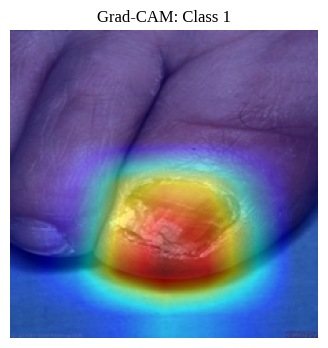

In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import timm
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load your trained model
model_name = 'resnet50'  # or 'resnet50'
model = timm.create_model(model_name, pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load("/mnt/c/Users/pragy/Downloads/Dataset/SD260/Models/resnet50.pth", map_location=torch.device("cpu")))
model.eval().to(DEVICE)

# Choose target layer
if "efficientnet" in model_name:
    target_layer = model.conv_head
elif "resnet" in model_name:
    target_layer = model.layer4[-1]
else:
    raise ValueError("Unsupported model for GradCAM")

# Preprocess image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_path = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/test/Tinea_Ringworm/036022VB.jpg"
img_pil = Image.open(img_path).convert("RGB")
input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)
rgb_img = np.array(img_pil.resize((224, 224))) / 255.0  # for visualization
# Forward pass
with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()

# Run Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer])
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Show result
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

targets = [ClassifierOutputTarget(pred_class)]  # Optional: class index

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Show result
plt.figure(figsize=(6, 4))
plt.imshow(cam_image)
plt.axis('off')
plt.title(f"Grad-CAM: Class {pred_class}")
plt.show()


In [26]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import timm
from collections import Counter
import time
import pandas as pd
from tqdm import tqdm
import os

# ✅ Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Constants
DATASET_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset"
SAVE_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/SD260/Split_Dataset/Features_Same_Dataset"
BATCH_SIZE = 32
IMG_SIZE = 224

# ✅ Data Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5439, 0.4471, 0.4324], std=[0.2387, 0.2132, 0.2141])
])

# ✅ Custom Dataset that returns file paths
from torchvision.datasets import ImageFolder
from PIL import Image

class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label, path

# ✅ Load Dataloaders
def get_dataloaders():
    train_set = ImageFolderWithPaths(os.path.join(DATASET_DIR, "train"), transform=transform)
    val_set = ImageFolderWithPaths(os.path.join(DATASET_DIR, "val"), transform=transform)
    test_set = ImageFolderWithPaths(os.path.join(DATASET_DIR, "test"), transform=transform)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, len(train_set.classes)

# ✅ Get Dataloaders
train_loader, val_loader, test_loader, num_classes = get_dataloaders()



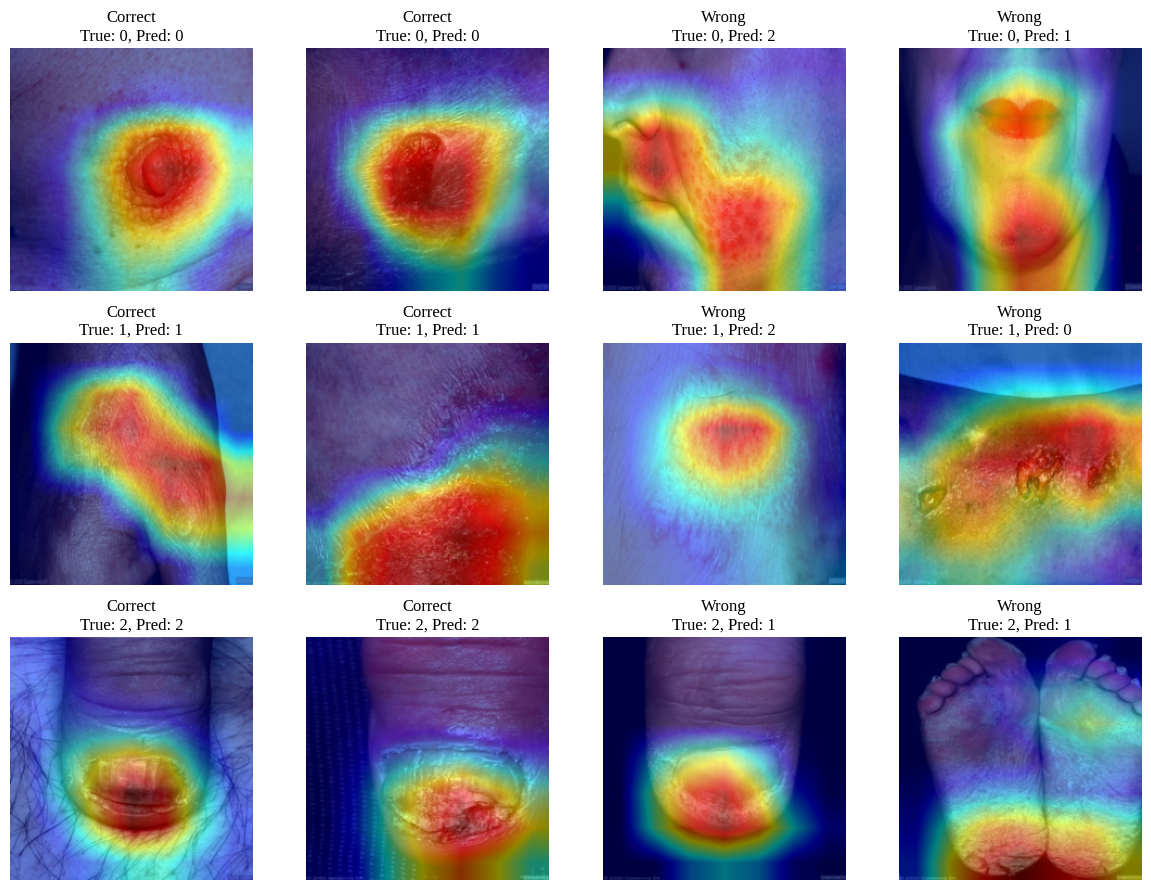

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from collections import defaultdict
from torchvision import transforms
from matplotlib import font_manager as fm

# ✅ Use the correct Liberation Serif font
font_path = "/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf"

# ✅ Force-add the font
fm.fontManager.addfont(font_path)

# ✅ Create a font properties object
liberation_font = fm.FontProperties(fname=font_path)
# ✅ Apply the font globally to all plots
plt.rcParams['font.family'] = liberation_font.get_name()

# ====================
# PARAMETERS
# ====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(DEVICE)
num_classes = 3  # change as needed
if "efficientnet" in model_name:
    target_layer = model.conv_head
elif "resnet" in model_name:
    target_layer = model.layer4[-1]
else:
    raise ValueError("Unsupported model for GradCAM")


# Transformation to convert tensor -> image
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.],
                         std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                         std=[1., 1., 1.])
])

# ====================
# COLLECT PREDICTIONS
# ====================
correct_per_class = defaultdict(list)
wrong_per_class = defaultdict(list)

with torch.no_grad():
    for images, labels,paths in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for img, label, pred, path in zip(images, labels, preds, paths):
            img_cpu = img.cpu()
            if label.item() == pred.item():
                if len(correct_per_class[label.item()]) < 2:
                    correct_per_class[label.item()].append((img_cpu, pred.item(), path))
            else:
                if len(wrong_per_class[label.item()]) < 2:
                    wrong_per_class[label.item()].append((img_cpu, pred.item(), path))

# ====================
# GRADCAM + PLOTTING
# ====================
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

fig, axs = plt.subplots(num_classes, 4, figsize=(12, 3*num_classes))

for class_idx in range(num_classes):
    # Get 2 correct and 2 wrong
    correct = correct_per_class[class_idx]
    wrong = wrong_per_class[class_idx]

    all_imgs = correct + wrong  # [(img, pred, path), ...]

    for i, (img_tensor, pred_class, path) in enumerate(all_imgs):
        input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

        # For visualization
        img_for_viz = inv_transform(img_tensor).numpy().transpose(1, 2, 0)
        img_for_viz = np.clip(img_for_viz, 0, 1)

        # GradCAM
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=[ClassifierOutputTarget(pred_class)])[0]
        cam_image = show_cam_on_image(img_for_viz, grayscale_cam, use_rgb=True)

        # Plot
        axs[class_idx, i].imshow(cam_image)
        axs[class_idx, i].axis('off')
        axs[class_idx, i].set_title(
            f"{'Correct' if i < 2 else 'Wrong'}\nTrue: {class_idx}, Pred: {pred_class}",
            fontsize=12
        )

plt.tight_layout()
plt.show()


In [20]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import timm
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load your trained model
model_name = 'efficientnet_b0'  # or 'resnet50'
model = timm.create_model(model_name, pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load("/mnt/c/Users/pragy/Downloads/Dataset/Original Images/Split_Dataset/Models/efficientnet_b0.pth", map_location=torch.device("cpu")))
model.eval().to(DEVICE)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [20]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import timm
from collections import Counter
import time
import pandas as pd
from tqdm import tqdm
import os

# ✅ Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Constants
DATASET_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/Original Images/Split_Dataset"
SAVE_DIR = "/mnt/c/Users/pragy/Downloads/Dataset/Original Images/Split_Dataset/Features_Same_Dataset"
BATCH_SIZE = 32
IMG_SIZE = 224

# ✅ Data Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5285, 0.3926, 0.3573], std=[0.2076, 0.1692, 0.1621])
])

# ✅ Custom Dataset that returns file paths
from torchvision.datasets import ImageFolder
from PIL import Image

class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label, path

# ✅ Load Dataloaders
def get_dataloaders():
    train_set = ImageFolderWithPaths(os.path.join(DATASET_DIR, "train"), transform=transform)
    val_set = ImageFolderWithPaths(os.path.join(DATASET_DIR, "val"), transform=transform)
    test_set = ImageFolderWithPaths(os.path.join(DATASET_DIR, "test"), transform=transform)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, len(train_set.classes)

# ✅ Get Dataloaders
train_loader, val_loader, test_loader, num_classes = get_dataloaders()



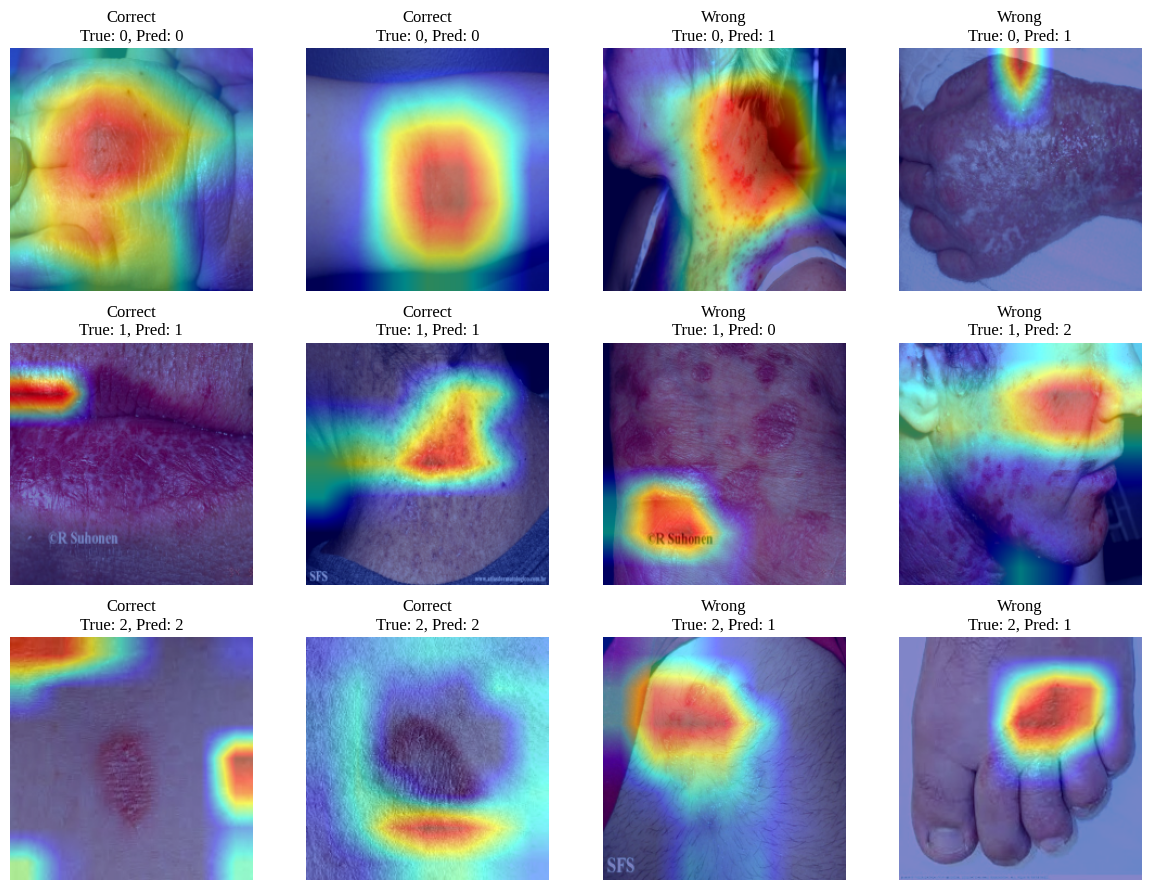

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from collections import defaultdict
from torchvision import transforms
from matplotlib import font_manager as fm

# ✅ Use the correct Liberation Serif font
font_path = "/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf"

# ✅ Force-add the font
fm.fontManager.addfont(font_path)

# ✅ Create a font properties object
liberation_font = fm.FontProperties(fname=font_path)
# ✅ Apply the font globally to all plots
plt.rcParams['font.family'] = liberation_font.get_name()

# ====================
# PARAMETERS
# ====================
NUM_CLASSES = 3
model_name = 'efficientnet_b0'  # or 'resnet50'
model = timm.create_model(model_name, pretrained=False, num_classes=NUM_CLASSES)

model.eval().to(DEVICE)


num_classes = 3  # change as needed
if "efficientnet" in model_name:
    target_layer = model.conv_head
elif "resnet" in model_name:
    target_layer = model.layer4[-1]
else:
    raise ValueError("Unsupported model for GradCAM")


model.load_state_dict(torch.load("/mnt/c/Users/pragy/Downloads/Dataset/Original Images/Split_Dataset/Models/efficientnet_b0.pth", map_location=torch.device("cpu")))
model.eval().to(DEVICE)
# Transformation to convert tensor -> image
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.],
                         std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                         std=[1., 1., 1.])
])

# ====================
# COLLECT PREDICTIONS
# ====================
correct_per_class = defaultdict(list)
wrong_per_class = defaultdict(list)

with torch.no_grad():
    for images, labels,paths in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for img, label, pred, path in zip(images, labels, preds, paths):
            img_cpu = img.cpu()
            if label.item() == pred.item():
                if len(correct_per_class[label.item()]) < 2:
                    correct_per_class[label.item()].append((img_cpu, pred.item(), path))
            else:
                if len(wrong_per_class[label.item()]) < 2:
                    wrong_per_class[label.item()].append((img_cpu, pred.item(), path))

# ====================
# GRADCAM + PLOTTING
# ====================
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

fig, axs = plt.subplots(num_classes, 4, figsize=(12, 3*num_classes))

for class_idx in range(num_classes):
    # Get 2 correct and 2 wrong
    correct = correct_per_class[class_idx]
    wrong = wrong_per_class[class_idx]

    all_imgs = correct + wrong  # [(img, pred, path), ...]

    for i, (img_tensor, pred_class, path) in enumerate(all_imgs):
        input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

        # For visualization
        img_for_viz = inv_transform(img_tensor).numpy().transpose(1, 2, 0)
        img_for_viz = np.clip(img_for_viz, 0, 1)

        # GradCAM
        grayscale_cam = cam(input_tensor=input_tensor,
                            targets=[ClassifierOutputTarget(pred_class)])[0]
        cam_image = show_cam_on_image(img_for_viz, grayscale_cam, use_rgb=True)

        # Plot
        axs[class_idx, i].imshow(cam_image)
        axs[class_idx, i].axis('off')
        axs[class_idx, i].set_title(
            f"{'Correct' if i < 2 else 'Wrong'}\nTrue: {class_idx}, Pred: {pred_class}",
            fontsize=12
        )

plt.tight_layout()
plt.show()


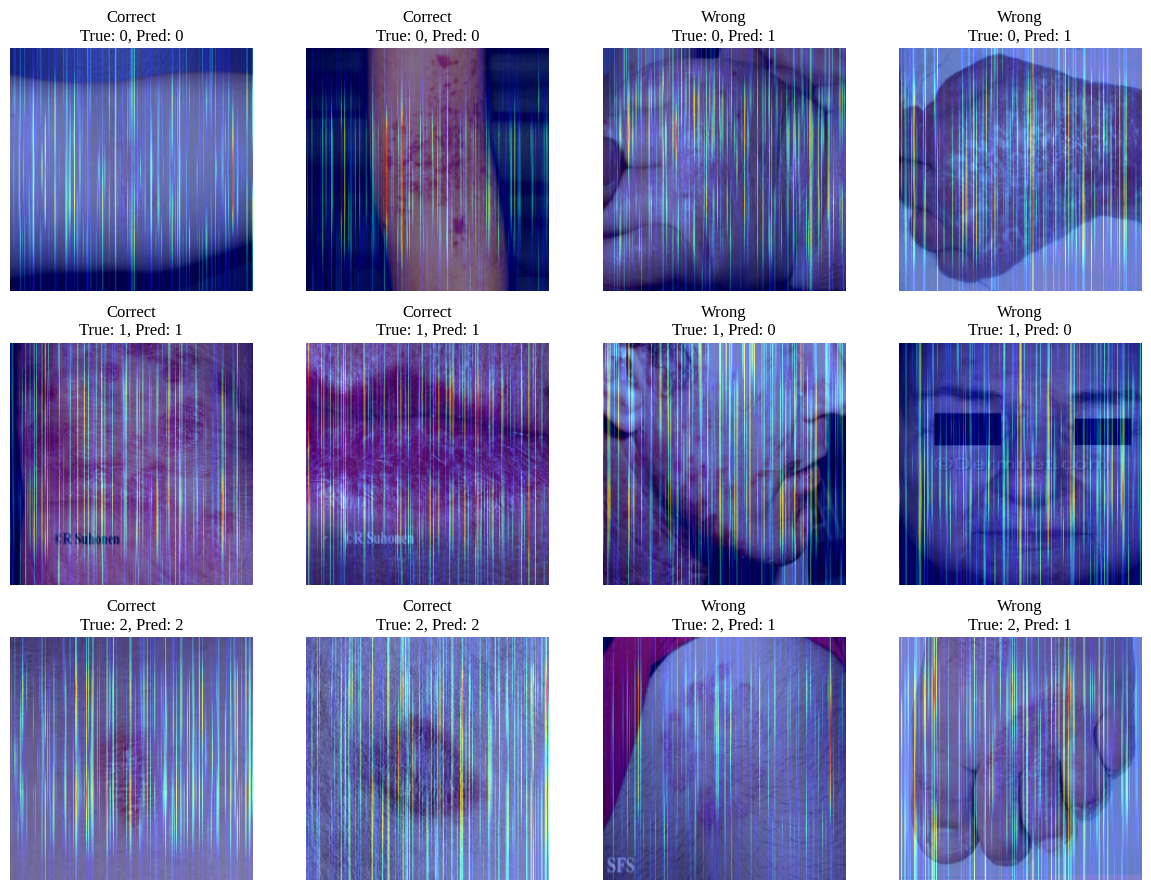

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from collections import defaultdict
from matplotlib import font_manager as fm
import timm  # Make sure timm is imported

# ====================
# FONT SETUP
# ====================
font_path = "/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf"
fm.fontManager.addfont(font_path)
liberation_font = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = liberation_font.get_name()

# ====================
# PARAMETERS
# ====================
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'swin_tiny'
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=NUM_CLASSES)

# Load weights
model.load_state_dict(torch.load("/mnt/c/Users/pragy/Downloads/Dataset/Original Images/Split_Dataset/Models/swin_tiny.pth", map_location=DEVICE))
model.eval().to(DEVICE)

# ====================
# TARGET LAYER FOR SWIN
# ====================
# For Swin, use the last layer before classification (head)
target_layer = model.norm  # Works for swin_tiny_patch4_window7_224

# ====================
# INVERSE TRANSFORM
# ====================
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
])

# ====================
# COLLECT PREDICTIONS
# ====================
correct_per_class = defaultdict(list)
wrong_per_class = defaultdict(list)

with torch.no_grad():
    for images, labels, paths in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for img, label, pred, path in zip(images, labels, preds, paths):
            img_cpu = img.cpu()
            if label.item() == pred.item():
                if len(correct_per_class[label.item()]) < 2:
                    correct_per_class[label.item()].append((img_cpu, pred.item(), path))
            else:
                if len(wrong_per_class[label.item()]) < 2:
                    wrong_per_class[label.item()].append((img_cpu, pred.item(), path))

# ====================
# GRADCAM + PLOTTING
# ====================
fig, axs = plt.subplots(NUM_CLASSES, 4, figsize=(12, 3*NUM_CLASSES))

with GradCAM(model=model, target_layers=[target_layer]) as cam:
    for class_idx in range(NUM_CLASSES):
        correct = correct_per_class[class_idx]
        wrong = wrong_per_class[class_idx]
        all_imgs = correct + wrong  # [(img, pred, path), ...]

        for i, (img_tensor, pred_class, path) in enumerate(all_imgs):
            input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

            # Inverse normalization for visualization
            img_for_viz = inv_transform(img_tensor).numpy().transpose(1, 2, 0)
            img_for_viz = np.clip(img_for_viz, 0, 1)

            # GradCAM
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=[ClassifierOutputTarget(pred_class)])[0]
            cam_image = show_cam_on_image(img_for_viz, grayscale_cam, use_rgb=True)

            # Plot
            axs[class_idx, i].imshow(cam_image)
            axs[class_idx, i].axis('off')
            axs[class_idx, i].set_title(
                f"{'Correct' if i < 2 else 'Wrong'}\nTrue: {class_idx}, Pred: {pred_class}",
                fontsize=12
            )

plt.tight_layout()
plt.show()
